# Product Sentiment Analysis - NLP

* Student name: Robert Cauvy 
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Claude Fried

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

Hired by Apple to determine which product release has the more positive sentiment and how it compared to their competitor Google who had also just released a new service.

Over the past decade conversations have increasingly shifted towards social media. Businesses across all industries could stand to benefit from listening to these conversations about themselves and how their products and brand are perceived by they users and prospective customers. Understanding what it is that customers enjoy the most and the least about your company's products and brand is crucial to retaining your loyal customers as well as attracting new ones.

When large companies announce their new product releases at conferences and keynotes, they can obtain useful market insights and feedback from public opinion. A great source to measure market reactions is the giant social media network, Twitter.

In addition to analyzing tweets various machine learning models will be trained and tested to classify tweets as either positive or negative sentiments towards the companies products and services. 

## Business Problem

It is not easy to obtain unbiased and unfiltered feedback and opinions from the public. Understanding how the market feels about the products and services delivered by your brand in real-time can provide valuable insights that could not get captured before the ubiquity of social media. Applying human capital to track social networks is simply not a scalable solution which makes the application of Natural Language Processing and Machine Learning classifiers well suited for this business problem.

The objective of this project is provide the businesses (Apple and Google) a model that identifies which tweets hold either a positive or negative sentiment about their brand or products from a corpus of tweets. Furthermore, this project will provide the stakeholders with a list of topics and keywords that most affect public perception, leaving actionable insights for future marketing and product design decisions.


# OBTAIN

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.set_option("display.max_colwidth", 300)

## Data Understanding

This project is utilizing a dataset  provided by CrowdFlower to from data.world. The dataset contains over 9,000 tweets from SXSW(South by Southwest) Conference about new product releases from Apple and Google. The tweet have been labeled as to which emotion they convey towards a particular product category or company brand based off of the language contained in the tweet.

According to the provider of the dataset, humans that were tasked with labeling the sentiments of each tweet by evaluating which brand or product the tweet was about and if the tweet expressed positive, negative, or no emotion towards a brand and/or product.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

In [3]:
df = pd.read_csv('data/tweet_product.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [4]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
# renaming columns to reduce verbosity
df = df.rename(columns={"tweet_text": "text", 
                   "emotion_in_tweet_is_directed_at": "product",
                  "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"
                  }
         )

In [6]:
#Cleaning up the values in sentinemts for easier interpretability

sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df.head()

,text,product,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
## Create a variable "corpus" containing all text
df['text'] = df['text'].astype(str)

corpus = df['text'].to_list()

## Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

In [9]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
text,0,0.00
product,5802,63.81
sentiment,0,0.00


*Nearly two thirds of tweets were labeled as having no emotion directed towards a specific brand or product.*

# Scrub

## Data Preparation

In [10]:
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

27

In [11]:
# Take a look at duplicated records
duplicates = df.duplicated(subset=['text'], keep=False)
df.loc[duplicates.loc[duplicates==True].index].sort_values(by='text')

,text,product,sentiment
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
774,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Neutral
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Neutral
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative
8483,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative


In [12]:
# drop duplicates
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

0

In [13]:
# check for URLs
df[df['text'].str.contains("http[^ ]+|www\.[^ ]+")]

,text,product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,Neutral
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive
11,Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.,Android App,Positive
12,"Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.",Android App,Positive
13,Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsandwich via @ischafer =&gt;http://bit.ly/aXZwxB,Other Google product or service,Positive
14,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,iPad or iPhone App,Positive
15,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",iPad or iPhone App,Positive
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,Neutral
19,Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV,iPad or iPhone App,Positive
23,"Photo: Just installed the #SXSW iPhone app, which is really nice! http://tumblr.com/x6t1pi6av7",iPad or iPhone App,Positive


In [14]:

# check for non-ASCII characters
df[df['text'].str.contains('[^\x00-\x7F]+')]

,text,product,sentiment
38,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative
41,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}",NaN,Neutral
42,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and weÛªll make you one!,NaN,Neutral
45,#IPad2 's Û÷#SmartCoverÛª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW,iPad or iPhone App,Positive
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},NaN,Positive
...,...,...,...
8925,umm that would be @mention ÛÏ@mention I keep winning shit! Thanks @mention for the killer iPad case. #sxswÛ,Other Apple product or service,Positive
8945,FestivalExplorer iPhone App Finally Solves SXSW {link} #music #musica #musiek #musique #musik #app #sxsw #Ù_¾¬â #Ù_¾´_ #Î¥É,iPad or iPhone App,Positive
8963,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}",Android App,Positive
8982,"In case my fairy god mother = reading mail; my ÌÙ±G wish this week is 2 go 2 #sxsw Ï for the #Android ÏÎ Dev Ïà Meetup. @mention Hilton, Sat. 12:30PM",NaN,Neutral


# EXPLORE

After going through some initial scrubbing of the dataset it is time to explore some of the characteristics of the tweet data. During this EDA phase, we will inspect the class balance, distribution of tweet lengths, WordClouds and most common words for each class. 

Because we are working with Twitter data, we'll work with nltk's TweetTokenizer and customize  stop words to get a better view of the content of the tweets for addressing the questions.

In [15]:
df['sentiment'].unique()

array(['Negative', 'Positive', 'Neutral', 'Unknown'], dtype=object)

In [16]:
sentiment_order = ('Negative', 'Positive',
       'Neutral', "Unknown")

sentiment_order

('Negative', 'Positive', 'Neutral', 'Unknown')

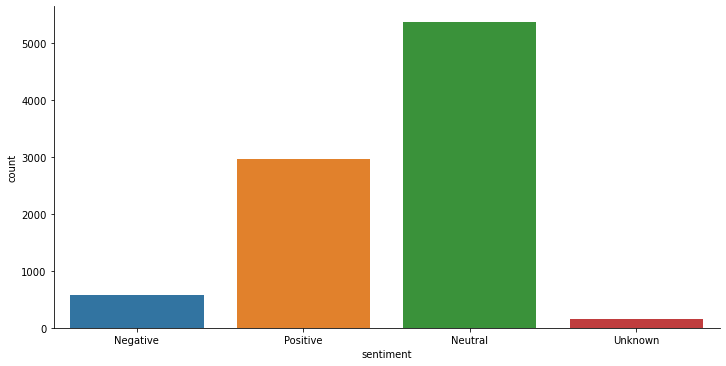

In [17]:
## Overall sentiment distribution
sns.catplot(data=df,x='sentiment',kind='count',order=sentiment_order,aspect=2);

#### Examing the class distributions

In [18]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [19]:
df['sentiment'].value_counts(normalize=True)

Neutral     0.592654
Positive    0.327377
Negative    0.062762
Unknown     0.017207
Name: sentiment, dtype: float64

Less than half of the tweets were classified as having any emotion. Of the tweets which were tagged as having an emotion, most were coded positive. About 3,000 tweets compared to only 570 tweets that were tagged as having negative emotion.

In [20]:
df[df['sentiment']=='Unknown']

,text,product,sentiment
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,NaN,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,NaN,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,NaN,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},NaN,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,NaN,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",NaN,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",NaN,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,NaN,Unknown


These tweets labeled as unknown are difficult to classify without more context and could be viewed as sarcastic.
All tweets in the corpus will need to be classified for modeling later on and the volume accounts for less than 2% of the corpus it is safe to drop these records.

In [21]:
df = df[df['sentiment']!='Unknown']
df['sentiment'].value_counts(normalize=True)

Neutral     0.603030
Positive    0.333109
Negative    0.063861
Name: sentiment, dtype: float64

### Make a Bag-of-Words Frequency Distribution

In [22]:
# Tokenize corpus then generate FreqDist
# Convert Corpus to Tokens
tokens = word_tokenize(','.join(corpus))

# Check first 5 tokens
print(tokens[:5])

['.', '@', 'wesley83', 'I', 'have']


In [23]:
# Get FreqDist and plot the 25 most_common tokens
freq = FreqDist(tokens)
freq.most_common(25)

[('#', 15875),
 (',', 12554),
 ('@', 7194),
 ('mention', 7119),
 ('.', 4929),
 ('SXSW', 4737),
 ('sxsw', 4478),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3928),
 ('to', 3519),
 ('RT', 2947),
 ('at', 2859),
 (';', 2800),
 ('&', 2707),
 ('for', 2440),
 ('!', 2398),
 ('a', 2174),
 ('Google', 2135),
 ('iPad', 2116),
 (':', 2075),
 ('Apple', 1880),
 ('in', 1830),
 ('quot', 1696)]

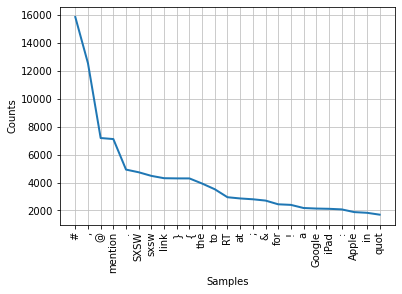

In [24]:
freq.plot(25);

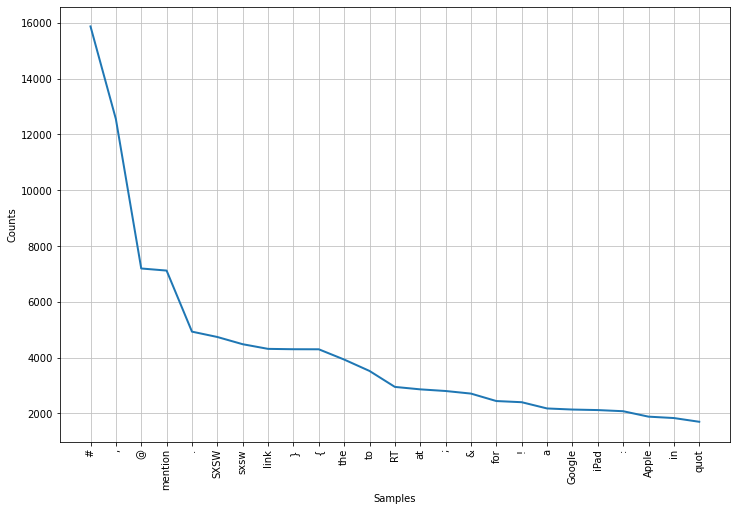

<ipython-input-25-814bc27432ef>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


In [25]:
fig, ax = plt.subplots(figsize=(12,8))
freq.plot(25);

## Rotate 
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,ha='right');
fig.show();

<AxesSubplot:ylabel='word'>

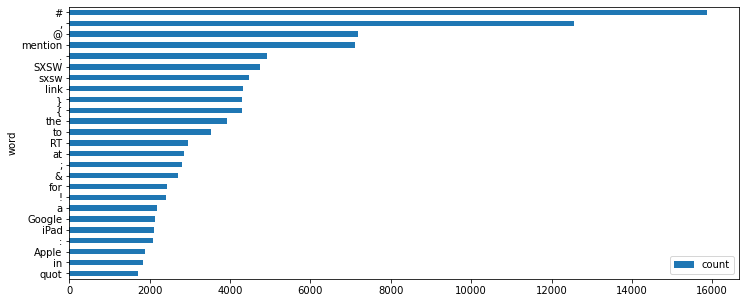

In [26]:
## Get the most_common 100 and make into a dataframe
most_common = pd.DataFrame(freq.most_common(100),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
most_common.set_index('word').tail(25).plot(kind='barh',figsize=(12,5))

In [27]:
most_common


,word,count
99,Today,250
98,ipad,251
97,'m,254
96,all,256
95,they,258
...,...,...
4,.,4929
3,mention,7119
2,@,7194
1,",",12554


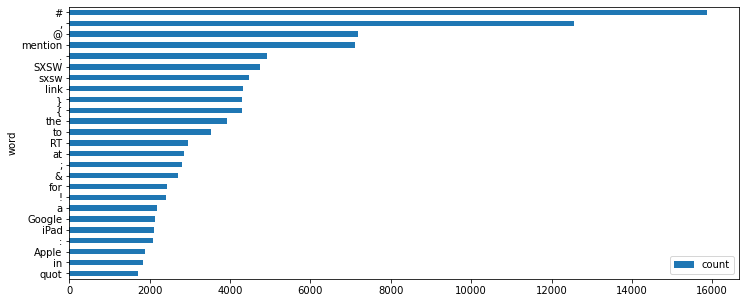

In [28]:
def plot_most_common(freq,n=25,figsize=(12,5)):
    most_common = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
    most_common.set_index('word').tail(n).plot(kind='barh',figsize=figsize)
    
plot_most_common(freq)

In [29]:
from nltk import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False,)
tweet_tokens = tokenizer.tokenize(','.join(corpus))
tweet_tokens[:20]

['.',
 '@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i']

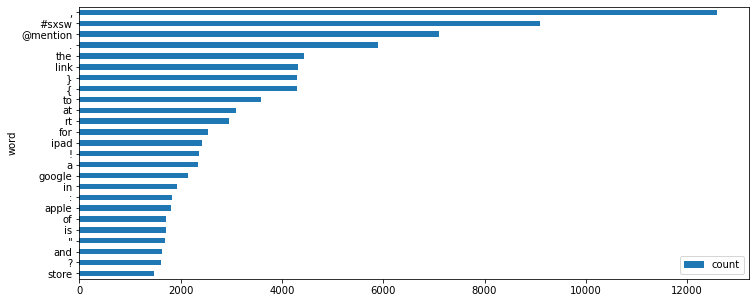

In [30]:
## Make a new freq dist for tweet tokens and plot most common
tweet_freq = FreqDist(tweet_tokens)
plot_most_common(tweet_freq)

In [31]:
## Make a list of stopwords to remove
from nltk.corpus import stopwords
import string

In [32]:
# Get all the stop words in the English language and preview first 10
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The stopwords list contains a good amount of words that can be used to express emotion. For this project, we'll use a more pared down list of custom stopwords.

In [33]:
# Customized smaller list of stopwords
custom_stopwords = ['i', 'me', 'my', 'myself', 'in', 'on', 'out','up','we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'of', 'at', 'by', 'for', 'with', 'about', 'into', 'through', 'to', 'from','then', 'no', 'nor', 'not', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'wasn']

In [34]:
# Adding punctuation to custom_stopwords
custom_stopwords.extend(string.punctuation)
custom_stopwords[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [40]:
# Adding additional ASCII/unicode Tweet Punctuation below to custom_stopwords
additional_punc = ['“','”','...',"''",'’','``','!']
custom_stopwords.extend(additional_punc)

In [41]:
# Appending stopwords list
custom_stopwords.extend(['…','rt','http','https','co'])
custom_stopwords[-1]

'co'

In [42]:
sxsw_stopwords = [custom_stopwords, 'sxsw', '#sxsw', '#sxswi','mention', '@mention', 
                  'google', 'apple', 'iphone','link' ,'rt']

In [43]:
sxsw_stopwords

[['i',
  'me',
  'my',
  'myself',
  'in',
  'on',
  'out',
  'up',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'into',
  'through',
  'to',
  'from',
  'then',
  'no',
  'nor',
  'not',
  'so',
  'than',
  'too',
  'very',
  's',
  't',
  'can',
  'will',
  'just',
  'don',
  'now',
  'd',
  'll',
  'm',
  'o',
  're',
  '

In [44]:
## Remove stopwords
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in sxsw_stopwords]
stopped_tokens[:20]

['.',
 '@wesley83',
 'i',
 'have',
 'a',
 '3g',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i',
 'need']

In [ ]:
# Remake the FreqDist from stopped_tokens
freq = FreqDist(stopped_tokens)
plot_most_common(freq,25)

In [ ]:
# Remake the FreqDist from stopped_tokens
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in custom_stopwords]
freq = FreqDist(stopped_tokens)
# freq.most_common(100)
plot_most_common(freq,25)

Since the business problem we are looking to solve requires understanding differences between positive and negative sentiments, it is essential that posiitive and negative twwets are separated for the exploration process.

In [ ]:
#separating positive and negative tweets into new dfs
positive_df = df[df['sentiment']=='Positive']
negative_df = df[df['sentiment']=='Negative']

In [ ]:
positive_df.head()

In [ ]:
negative_df.head()

In [ ]:
positive_corpus = positive_df['text'].to_list()
positive_corpus[:5]

In [ ]:
negative_corpus = negative_df['text'].to_list()
negative_corpus[:5]

In [ ]:
positive_tokens = [w.lower() for w in tweet_tokens  if w.lower() not in sxsw_stopwords]

## Most Common Words Found In Positive Tweets

In [76]:
def find_most_common(tokens, n=50):
    freq = FreqDist(tokens)
    display(freq.most_common(n))

In [77]:
# print 50 most common words from positive tweets
find_most_common(positive_tokens)

NameError: name 'positive_tokens' is not defined

In [78]:
from wordcloud import WordCloud

def generate_wordcloud(tokens, collocations=True, colormap='Greens', 
                       display=True):
    
    # Initalize a WordCloud with our stopwords_list and no bigrams
    wordcloud = WordCloud(collocations=collocations, colormap=colormap)

    # Generate wordcloud from stopped_tokens
    wordcloud.generate(','.join(stopped_tokens))

    # Plot with matplotlib
    plt.figure(figsize = (12, 12), facecolor = None ) 
    plt.imshow(wordcloud,interpolation='bilinear') 
    plt.axis('off');

In [79]:
positive_cloud = generate_wordcloud(positive_tokens)

NameError: name 'positive_tokens' is not defined

## Most Common Words Found in Negative Tweets


In [80]:
negative_corpus = negative_df['text'].to_list()
negative_corpus [:3]                            

NameError: name 'negative_df' is not defined

In [81]:
#tokenize tweets
negative_tokens = tokenize_tweets(negative_corpus
#lemmatize tweets
neg_tokens_lemma = lemmatize_tokens(negative_tokens)
#remove stop words & punctuation using the same stop words list
negative_stop = remove_stop(neg_tokens_lemma, stop_list = stop_lst)

SyntaxError: invalid syntax (<ipython-input-81-fd979832d699>, line 4)

## Tweet Length

In [ ]:
def count_words(doc):
    tokenizer_no_strip = TweetTokenizer(strip_handles=False)
    tokens = tokenizer_no_strip.tokenize(doc)
    return len(tokens)

df['token_count'] = df['text'].map(lambda x: count_words(x))
df.head()

In [ ]:
# visualize distribution of tweet lengths 
with sns.plotting_context(context='talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(df['token_count'], color='lightblue', ax=ax)
    ax.set_title('Distribution of Tweet Lengths')
    ax.set_xlabel('Number of Tokens in Tweet');

### Bag of Words Stats

In [ ]:
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
# Make a DataFrame from the Bigrams
pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(10)

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweet_pmi_finder.apply_freq_filter(3)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [ ]:
# Make a DataFrame from the Bigrams with PMI
pd.DataFrame(tweet_pmi_scored,columns=['Words','PMI']).head(20)

### RegEx

In [ ]:
## Select an example tweet
text =  corpus[9000]
text

In [ ]:
## Select a second example tweet
text2=corpus[5]
text2

In [ ]:
from nltk import regexp_tokenize
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
regexp_tokenize(text,pattern)

## Text Vectorization

* Count vectorization
* Term Frequency-Inverse Document Frequency (TF-IDF)
* Word Embeddings (Deep NLP)

### Summary: Feature Engineering for Text Data

# Methods

## Text Preprocessing Approach

Describe and justify the process for preparing the data for analysis.

* Removed @mentions, links, non-ASCII characters, and words consisting of only numbers
* Generated several stopwords lists using NLTK's list as the baseline
* Evaluated several different methods for generating frequency in Documemt Term Matrix: binary, count, and count with Tf-Idf normalization
* Tried using uni-grams, uni-grams + bi-grams, and just bi-grams
* Tested with and without applying stemming and lemmatization using NLTK
* Testing using original data with imbalanced classes as well as randomly oversampled data



***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

# MODEL

## Text Classification - Sentiment Analysis

### Objective - Classifying Tweet Sentiments as Positive, Negative or Neither


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Our modelling process was split in two: Binary Classification and Multiclass Classification. For each type of classification, data was prepared and a baseline dummy classifier model was trained to serve as a baseline. For comparison we trained/tested Random Forest models and Logistic Regression models for Multiclass Classification while adding on Multinomial Naive Bayes for the Binary Classification on top of these.

We evaluated each model and tuned hyperparameters with gridsearches that optimized for the recall macro scores since we wanted the models to correctly classify all classes. These steps were repeated after data was randomly oversampled.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

Tested Naive Bayes (Multinomial), Random Forest, and Logistic Regression classifiers
To determine optimal preprocessing steps, model type, and model hyperparameters, ran grid searches optimized for recall macro
Evaluated both binary (positive and negative) and multi-class (positive, negative, and no emotion) classification. Compared the all-in-one multi-class model to the performance if we used multi-class as the first pass, and the binary model as the second pass.

In [45]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [46]:
df.head()

,text,product,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive


In [48]:
## Check Value Counts for Product
df['product'].value_counts()

iPad                               939
Apple                              657
iPad or iPhone App                 469
Google                             427
iPhone                             295
Other Google product or service    292
Android App                         80
Android                             77
Other Apple product or service      35
Name: product, dtype: int64

In [49]:
## Check Value Counts for Sentiment
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Name: sentiment, dtype: int64

## Preprocessing

In [50]:
## Make X and y
y = df['sentiment'].copy()
X = df['text'].copy()
X

0                         .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
1             @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2                                                                         @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3                                                                      @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4                     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
                                                                              ...                                                                        
9088                                                                        

### Train Test Split


In [51]:
## Train Test Split (random state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)
X_train

6258                                 RT @mention listening to @mention discuss new interaction paradigms in designing for the ipad #uxdes #sxsw
3648                                             #iPad design/UI tip: ÛÏbuttons are a hack -approach them with skepticism ÛÏ #tapworthy #sxsw
6523                  RT @mention RT @mention CNN to launch &quot;TV everywhere&quot; service for mobile, Google TV and computers: {link} #SXSW
5903                        RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today @mention #sxsw #sxswi - {link}
4556                                                      is EVERYONE that works at google this genius??!?  Seriously smart AND artistic. #SXSW
                                                                         ...                                                                   
5847    RT @mention Google maps usage on mobile exceeded desktop usage on xmas and new years day for the first time ÛÓ Marissa Mayer at

In [52]:
## Check y_train value counts
y_train.value_counts(1)

Neutral     0.606061
Positive    0.333173
Negative    0.060766
Name: sentiment, dtype: float64

### Tokenization & Vectorization

In [53]:
## Make a TweekTokenizer from nltk.tokenize (preserve_case=False)
tokenizer = TweetTokenizer(preserve_case=False)

In [54]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<6237x8980 sparse matrix of type '<class 'numpy.float64'>'
	with 92557 stored elements in Compressed Sparse Row format>

In [55]:
## Compare the shape of X_train to X_train_tfidf

X_train.shape

(6237,)

In [56]:
## Check the len of the vectorizer's vocabulary
len(vectorizer.vocabulary_)

8980

## Baseline Model

In [57]:
## Make and fit a random forest  (class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train)


RandomForestClassifier(class_weight='balanced')

In [83]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=['Negative', 'Neutral','Positive'],figsize=(10,4),
                            X_train = None, y_train = None,):
   
    # Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    # Plot Confusion Matrix and ROC curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add score comparison if X_train and y_train provided
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")

In [84]:
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance

              precision    recall  f1-score   support

    Negative       0.65      0.17      0.27       190
     Neutral       0.69      0.90      0.78      1593
    Positive       0.68      0.43      0.53       890

    accuracy                           0.69      2673
   macro avg       0.68      0.50      0.53      2673
weighted avg       0.69      0.69      0.66      2673



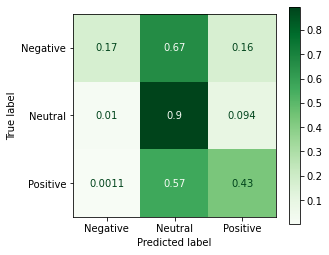

Training Score = 1.00
Test Score = 0.69


In [85]:
## Evaluate Model using function
evaluate_classification(rf,X_test_tfidf,y_test,X_train=X_train_tfidf,y_train=y_train)

In [86]:
pd.DataFrame(X_train_tfidf.todense(), columns=vectorizer.get_feature_names())

,!,"""",#,##apple_store,##sxsw,##uxdes,#100tc,#106,#11ntc,#13,...,ûïview,ûïwin,ûò,ûòand,ûó,ûójust,ûólewis,ûólots,ûóthe,ü
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.316402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.131795,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.27784,0.0,0.0,0.0,0.0,0.0
6233,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
6234,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
6235,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


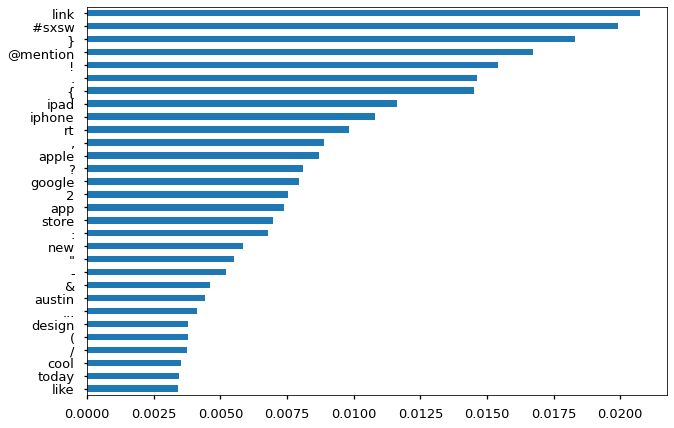

In [87]:
# Plot the top 30 most important features
with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

## Pipelines and GridSearch for NLP

In [88]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.pipeline import Pipeline

In [89]:
from sklearn import set_config
set_config(display='diagram')

In [90]:
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer()),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])
text_pipe

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tf_transformer', TfidfTransformer())])

In [91]:
## Test out the text pipeline on X_train
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

<6237x8335 sparse matrix of type '<class 'numpy.float64'>'
	with 101482 stored elements in Compressed Sparse Row format>

In [92]:
## Make a full pipeline with the random forest model as the second step
full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced'))])
full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                 ('tf_transformer', TfidfTransformer())])),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

              precision    recall  f1-score   support

    Negative       0.68      0.18      0.28       190
     Neutral       0.67      0.91      0.77      1593
    Positive       0.68      0.36      0.47       890

    accuracy                           0.67      2673
   macro avg       0.68      0.48      0.51      2673
weighted avg       0.67      0.67      0.64      2673



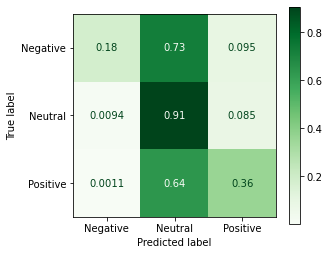

Training Score = 1.00
Test Score = 0.67


In [73]:
# Modeling with full pipeline
full_pipe.fit(X_train,y_train)
evaluate_classification(full_pipe,X_test,y_test,X_train=X_train, y_train=y_train)

### GridSearching NLP Pipeline

In [74]:
full_pipe.named_steps['text_pipe']

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tf_transformer', TfidfTransformer())])

In [98]:
## Make a tokenizer with TweetTokenizer

## Make params grid
## transformer params: use_idf/norm,smooth_idf
### tokenizers: try different TweetTokeinzier

## Vectorizer:stop_wqords/max_df/min_df,

## randomforest: criterion/max_depth
params = {'text_pipe__tf_transformer__use_idf':[True,False],
          'text_pipe__tf_transformer__norm':['l2','l1'],
          'text_pipe__tf_transformer__smooth_idf':[True,False],
          'text_pipe__count_vectorizer__stop_words':[stopwords_list,None],
          'text_pipe__count_vectorizer__max_df':[1.0,0.95],
          'text_pipe__count_vectorizer__min_df':[1,2,3],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 10, 30, 50]
         }

## Make and fit grid
grid = GridSearchCV(full_pipe,
                   params, cv=3, scoring='recall',n_jobs=-1, verbose=2)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
## Evluate the best_estimator
evaluate_classification(grid.best_estimator_, X_test,y_test, 
                        X_train=X_train, y_train=y_train)

### Get feature importances as text

### Gaussian Naive Bayes

In [99]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(X_tr,y_tr)
evaluate_classification(bayes,X_te,y_te,X_train=X_tr,y_train=y_tr)

NameError: name 'X_tr' is not defined

In [ ]:
## Use text pipe to get X_train,X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

In [ ]:
## Make a naive bayes classifier
nb_classifier = MultinomialNB()#alpha = 1.0e-08)
nb_classifier.fit(X_train_pipe,y_train)
evaluate_classification(nb_classifier,X_test_pipe,y_test, X_train=X_train_pipe,
                       y_train=y_train)

In [ ]:
# Make a new pipeline for bayes

nb_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',MultinomialNB())
])


params = {'text_pipe__tf_transformer__use_idf':[True, False],
          'text_pipe__tf_transformer__norm':['l2','l1'],
          'text_pipe__tf_transformer__use_idf':[True,False],
          'text_pipe__tf_transformer__smooth_idf':[True,False],
#           'text_pipe__count_vectorizer__tokenizer':[ 
# #               None,                                       
#               TweetTokenizer(preserve_case=True).tokenize,
#               TweetTokenizer(preserve_case=False).tokenize],
          
          'text_pipe__count_vectorizer__stop_words':[None,stopwords_list],
#           'text_pipe__count_vectorizer__max_df':[1.0,0.95,0.9],
#           'text_pipe__count_vectorizer__min_df':[1,2,3],
          
         'clf__alpha':[0, 1],
         'clf__fit_prior':[True,False]}


## Make and fit grid
grid = GridSearchCV(nb_pipe,params,cv=3,scoring='recall_macro',
                   verbose=2, n_jobs=-1)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


In [ ]:
## Evluate the best_estimator
best_pipe = grid.best_estimator_
evaluate_classification(best_pipe,X_test,y_test,X_train=X_train,y_train=y_train)

## Best Model

The best model for both binary and muli-class classification problems were both Logistic Regression. The models agreed on most preprocessing and model hyperparameters, but differed in a few ways:

### Multi-Class Model Results

Best model achieved ~60-65% balanced accuracy across all classes on unseen test data
~30% better than guessing randomly based on class distribution
Identified about the same percentage of True Positives for any class, although confused Positive and No Sentiment more often than either of these with Negative

### Binary Model Results

Best model achieved ~75% balanced accuracy across both classes on unseen test data
~25% better than guessing randomly based on class distribution
Better at predicting positive sentiment than negative: only ~10-15% of Positives misclassified as Negative, while ~30-40% of Negatives misclassified as Positive

# Results

Evaluate how well your work solves the stated business problem.

The winner of this task was the tuned oversampled logistic regression model with a recall macro score of 0.62. The tuned random oversampled logistic regression model also scored the same 0.62; however, since it got to the same score only after the random oversampling we are declaring the non-oversampled model as the winner.



***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Model Insights

# CONCLUSIONS & RECOMMENDATIONS

## Recommendations

## Limitations & Next Steps